>**Convolutional Neural Network (CNN)**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print("PyTorch version {}".format(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device: {}".format(device))

PyTorch version 1.9.0+cu102
device: cuda:0


>**Dataset**

In [35]:
from torchvision import datasets, transforms
mnist_train = datasets.MNIST(root='./data/',train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./data/',train=False, transform=transforms.ToTensor(), download=True)
print("mnist_train:\n",mnist_train,'\n')
print("mnist_test:\n",mnist_test,'\n')
print("Done")

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done


In [36]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


>**DEFINE MODEL**

In [28]:
class ConvolutionalNeuralNetworkClass(nn.Module):

  def __init__(self,name='cnn',xdim=[1,28,28],ksize=3,cdims=[32,64],hdims=[1024,128],ydim=10,USE_BATCHNORM=False):
    super(ConvolutionalNeuralNetworkClass,self).__init__()
    self.name=name
    self.xdim = xdim
    self.ksize = ksize
    self.cdims = cdims
    self.hdims = hdims
    self.ydim = ydim
    self.USE_BATCHNORM = USE_BATCHNORM

    self.layers = []
    prev_cdim = self.xdim[0]
    for cdim in self.cdims:
      self.layers.append(
          nn.Conv2d(in_channels=prev_cdim,
                    out_channels=cdim,
                    kernel_size=self.ksize,
                    stride=(1,1),
                    padding=self.ksize//2)
      )
      if self.USE_BATCHNORM:
        self.layers.append(nn.BatchNorm2d(cdim))

      self.layers.append(nn.ReLU(True))
      self.layers.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))) # max-pooling
      self.layers.append(nn.Dropout2d(p=0.5))
      prev_cdim = cdim
      
    #Dense layers
    self.layers.append(nn.Flatten())
    prev_hdim = prev_cdim * (self.xdim[1]//(2**len(self.cdims))) * (self.xdim[2]//(2**len(self.cdims)))
    for hdim in self.hdims:
      self.layers.append(nn.Linear(
          prev_hdim, hdim, bias=True
      ))
      self.layers.append(nn.ReLU(True)) # activation
      prev_hdim = hdim

    #Final layer(no activation function)
    self.layers.append(nn.Linear(prev_hdim,self.ydim,bias=True))

    self.net = nn.Sequential()
    for l_idx, layer in enumerate(self.layers):
      layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
      self.net.add_module(layer_name,layer)
    self.init_param()

  def init_param(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias,0)
      elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)

  def forward(self,x):
    return self.net(x)

C = ConvolutionalNeuralNetworkClass(name='cnn',xdim=[1,28,28],ksize=3,cdims=[32,64],hdims=[32],ydim=10).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(C.parameters(), lr=1e-3)
print("Done")

Done


In [29]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(C.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array 
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[net.conv2d_00.weight] shape:[(32, 1, 3, 3)].
    val:[ 0.197  0.47   0.097 -1.16  -0.461]
[1] name:[net.conv2d_00.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[2] name:[net.conv2d_04.weight] shape:[(64, 32, 3, 3)].
    val:[ 0.069 -0.052 -0.047  0.039 -0.067]
[3] name:[net.conv2d_04.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[4] name:[net.linear_09.weight] shape:[(32, 3136)].
    val:[ 0.003  0.015 -0.022  0.019  0.031]
[5] name:[net.linear_09.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[6] name:[net.linear_11.weight] shape:[(10, 32)].
    val:[-0.013 -0.433 -0.107 -0.033 -0.244]
[7] name:[net.linear_11.bias] shape:[(10,)].
    val:[0. 0. 0. 0. 0.]
Total number of parameters:[119,530].


In [31]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(2,1,28,28)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = C.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("\nx_numpy %s:\n"%(x_numpy.shape,),x_numpy)
print ("y_numpy %s:\n"%(y_numpy.shape,),y_numpy)

x_torch:
 tensor([[[[0.159, 0.272, 0.005,  ..., 0.180, 0.594, 0.975],
          [0.886, 0.676, 0.454,  ..., 0.477, 0.835, 0.172],
          [0.789, 0.834, 0.932,  ..., 0.443, 0.098, 0.581],
          ...,
          [0.249, 0.796, 0.057,  ..., 0.117, 0.809, 0.110],
          [0.472, 0.520, 0.433,  ..., 0.752, 0.828, 0.787],
          [0.631, 0.749, 0.946,  ..., 0.801, 0.035, 0.606]]],


        [[[0.504, 0.928, 0.759,  ..., 0.062, 0.696, 0.502],
          [0.442, 0.859, 0.998,  ..., 0.290, 0.718, 0.416],
          [0.317, 0.178, 0.543,  ..., 0.513, 0.544, 0.793],
          ...,
          [0.909, 0.775, 0.157,  ..., 0.681, 0.640, 0.749],
          [0.770, 0.321, 0.475,  ..., 0.727, 0.374, 0.324],
          [0.718, 0.258, 0.455,  ..., 0.926, 0.990, 0.493]]]], device='cuda:0')
y_torch:
 tensor([[-1.270, -3.298, -6.383,  6.988,  0.327,  1.813, -2.659,  0.146, -3.522,
          0.965],
        [-2.648,  3.902,  2.912,  2.076, -2.884, -4.039,  1.777,  2.170,  2.541,
         -0.822]], device=

>**Evaluation Function**

In [34]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct = 0,0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1,1,28,28).to(device))
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


>**Initial Evaluation**


In [37]:
C.init_param() # initialize parameters
train_accr = func_eval(C,train_iter,device)
test_accr = func_eval(C,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.098] test_accr:[0.095].


>**Train**

In [39]:
print ("Start training.")
C.init_param() # initialize parameters
C.train() # to train mode 
EPOCHS,print_every = 10,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = C.forward(batch_in.view(-1,1,28,28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad()      # reset gradient 
        loss_out.backward()      # backpropagate
        optm.step()      # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(C,train_iter,device)
        test_accr = func_eval(C,test_iter,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")

Start training.
epoch:[0] loss:[0.598] train_accr:[0.954] test_accr:[0.956].
epoch:[1] loss:[0.181] train_accr:[0.973] test_accr:[0.973].
epoch:[2] loss:[0.126] train_accr:[0.981] test_accr:[0.980].
epoch:[3] loss:[0.103] train_accr:[0.985] test_accr:[0.985].
epoch:[4] loss:[0.089] train_accr:[0.986] test_accr:[0.987].
epoch:[5] loss:[0.080] train_accr:[0.988] test_accr:[0.986].
epoch:[6] loss:[0.071] train_accr:[0.990] test_accr:[0.986].
epoch:[7] loss:[0.067] train_accr:[0.990] test_accr:[0.987].
epoch:[8] loss:[0.061] train_accr:[0.992] test_accr:[0.988].
epoch:[9] loss:[0.059] train_accr:[0.992] test_accr:[0.988].
Done


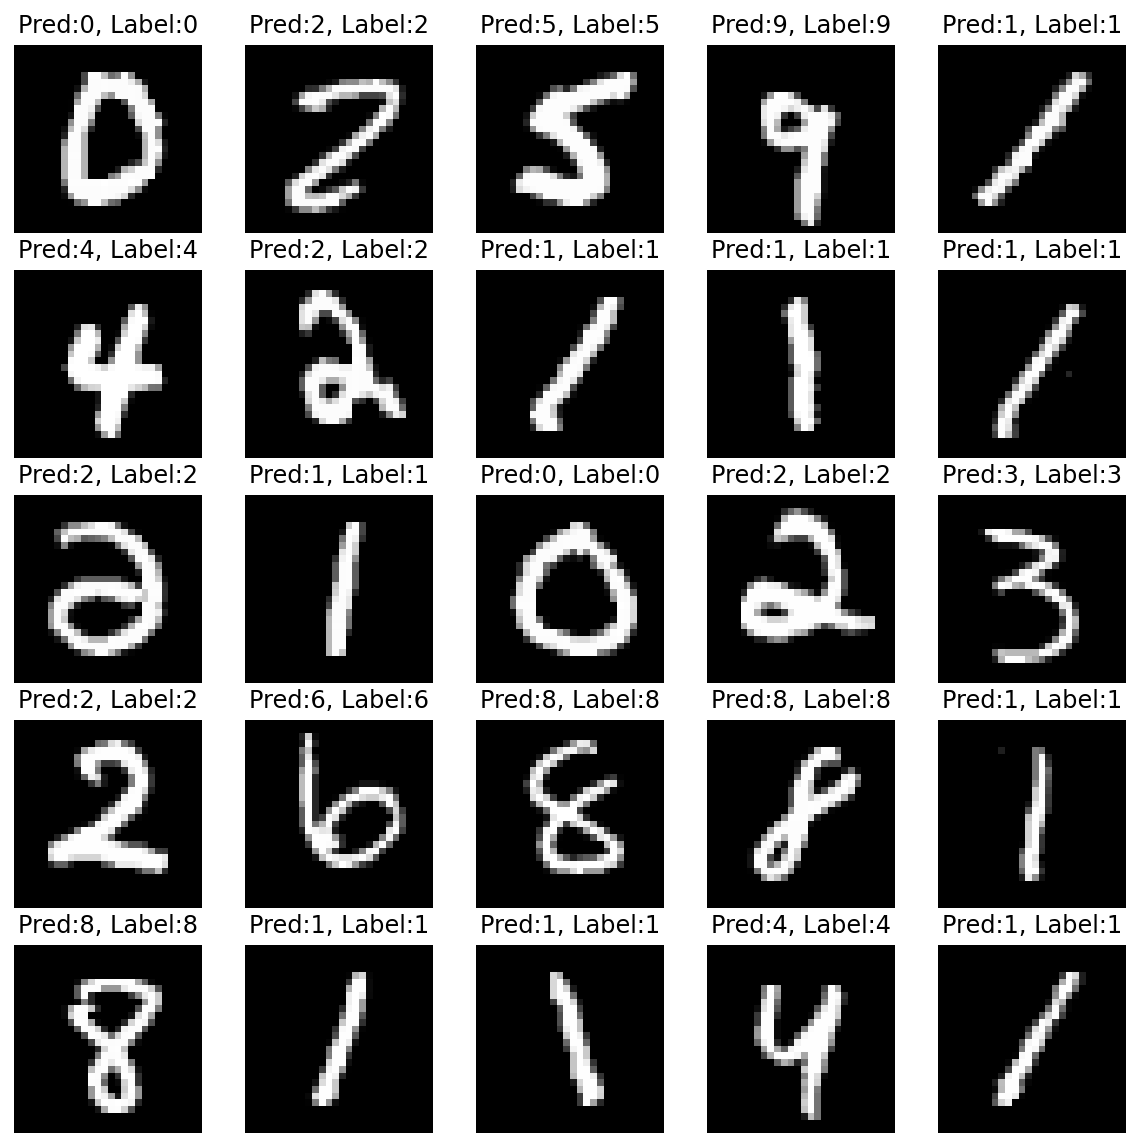

Done


In [43]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets),n_sample,replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    C.eval() # to evaluation mode 
    y_pred = C.forward(test_x.view(-1,1,28,28).type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()    
print ("Done")